# Self-Consistency with Board Game Questions

In [1]:
from meeplemate.llm_models import load_tgi_chat_model, load_tokenizer

tgi_url = "http://tgi:80"

chat_model = load_tgi_chat_model(
    inference_server_url=tgi_url,
    max_new_tokens=512,
    timeout=900,
    do_sample=False,
    temperature=0.01,
)

tokenizer = chat_model.tokenizer

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

cot_prompt_template = """\
Answer the following board game question based on the given rules from the \
rulebook. Provide your step-by-step reasoning first followed by the answer. \
Each step should be a separate bullet point. Remember rules found in a board \
game rulebook generally hold unless there is an explicit exception.

> Context:
>>>
{context}
>>>
> Question: {question}
> Answer: Let's think step by step. \
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("human", cot_prompt_template),
    ],
)

context_when_take_actions = """\
You may perform these actions at any time:
- Discard a Class or Race.
- Play a Go Up a Level or Hireling.
- Play a Curse.

You may perform these actions at any time, as long as you are not in combat:
- Trade an Item with another player (the other player may not be in combat, either).
- Change which Items you have equipped.
- Play a card that you have just received (some cards may be played even during combat; see above).

You may perform these actions on your own turn:
- Play a new Class or Race card (at any time).
- Sell Items for levels (except when you are in combat).
- Play an Item (most Items cannot be played during combat)
"""

question = "Can I play a Go Up a Level card while in combat?"

In [3]:
cot_chain = (prompt | chat_model | StrOutputParser())

print(
    cot_chain.invoke({"context": context_when_take_actions, "question": question})
)

Step 1: Review the rules for playing Go Up a Level cards. The rulebook states that "you may perform these actions at any time, as long as you are not in combat."

Step 2: Identify the current situation. The question states that you are "in combat."

Step 3: Compare the current situation to the rules. The rules state that you cannot play a Go Up a Level card while in combat.

Step 4: Provide the answer based on the comparison. No, you cannot play a Go Up a Level card while in combat.


In [4]:
extract_prompt = ChatPromptTemplate.from_messages(
    [
        ("assistant", "{answer}"),
        ("human", "And so the answer is:")
    ]
)

cot_chain = (prompt | chat_model | StrOutputParser())

chain = (
    {"answer": cot_chain}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

print(
    chain.invoke({"context": context_when_take_actions, "question": question})
)

You cannot play a Go Up a Level card while in combat.


## Self-Consistency

"Self-Consistency Improves Chain of Thought Reasoning in Language Models" (https://arxiv.org/abs/2203.11171)

### tl;dr

1. Sample LLM (e.g. by increasing temperature) with CoT prompt multiple times
    * Multiple correct reasoning paths lead to the same correct answer
    * Bad reasoning paths lead to a variety of bad answers (not the same one)
2. Return most consistent response

In [5]:
from langchain_core.runnables import RunnableLambda
import copy

def build_duplicator(n):
    def duplicator(x):
        return [copy.copy(x) for _ in range(n)]
    return RunnableLambda(duplicator)

cot_chain = (
    prompt | chat_model.bind(temperature=0.7) | StrOutputParser()
)

cot_and_extract_chain = (
    {"answer": cot_chain}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_and_extract_chain.map()
)

outputs = chain.invoke({"context": context_when_take_actions, "question": question})
for output in outputs:
    print(output)
    print()
    print("----")
    print()

Yes, you can play a Go Up a Level card during combat, as long as you meet the conditions mentioned in the rule.

----

Yes, you can play a Go Up a Level card while in combat, as the rule does not specifically state that you cannot.

----

Yes, you can play a Go Up a Level card while in combat.

----

You cannot play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----



### Which "yes" is the right "yes"?

Clearly, the consensus answer is "Yes", but which "Yes". We have multiple explanations for the answer:
- Yes, you can play a Go Up a Level card while in combat.
- Yes, you can play a Go Up a Level card while in combat, as it is a card that you have just received and falls under the rule that allows playing some cards during combat.

### What about questions where both "yes" and "no" can be correct?

Consider the question, "can I have two steeds in play?" It has multiple correct answers:
- No, you can only have one steed in play at a time.
- No, you can only have one steed in play at a time, unless you use a Cheat! card.
- Yes, you can have two steeds in play, so long as you use a Cheat! card.

### What about open ended questions in general?

- How do I setup the game?
- What happens when my character dies?
- How is combat resolved?
- etc.

## Universal Self-Consistency

"Universal Self-Consistency for Large Language Model Generation" (https://arxiv.org/abs/2311.17311)

### tl;dr

1. Sample LLM and collect responses
2. Shove questions and all responses into a prompt and ask LLM to tell us the most consistent answer

Tried this, it didn't work particularly great for this use case.

## Embeddings and Highest Average Similarity

1. We already have an embedding model for querying vector database
2. Embed the responses and compute cosine similarity between all responses
3. Correct answers should cluster, incorrect should spread out in vector space
4. Response with highest-average cosine similarity is consensus answer

In [ ]:
from meeplemate.llm_models import load_jina_embedding_model
import numpy as np

In [7]:
def visualize_similarity(responses, similarity_scores, number_correct=None, title=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics.pairwise import cosine_similarity
    from meeplemate.consistency import embed_responses
    from matplotlib.patches import Rectangle

    plt.figure(figsize=(10, 8))

    if title is not None:
        plt.title(title)

    ax = sns.heatmap(similarity_scores, annot=True, cmap='coolwarm')
    if number_correct is not None:
        rect_first_group = Rectangle((0, 0), number_correct, number_correct, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(rect_first_group)

    plt.show()

In [ ]:
embedding_model = load_jina_embedding_model()

def embedding_similarity_score(responses):
    responses = [response["text"] for response in responses]
    vectors = embedding_model.encode(responses, normalize_embeddings=True)
    dot_product = vectors.dot(vectors.T)
    return dot_product

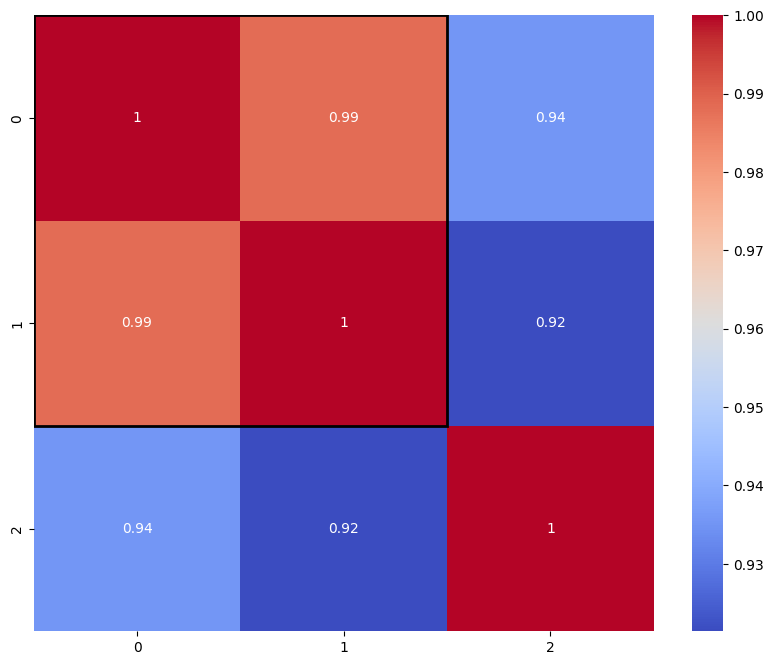

In [9]:
responses = [
    {"text": "Yes, you may play a Go Up a Level card during combat."},
    {"text": "You may play a Go Up a Level card during combat."},
    {"text": "No, you may not play a Go Up a Level card during combat."},
]
similarity_scores = embedding_similarity_score(responses)
visualize_similarity(responses, similarity_scores, 2)

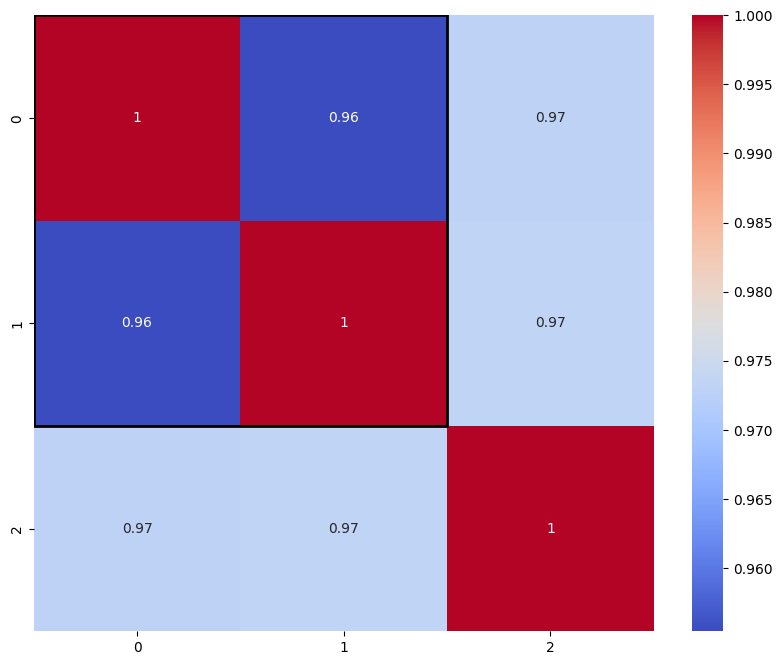

In [10]:
response_0 = (
    "If a hireling is removed from play due to Bad Stuff, the player does not "
    "retain any items the hireling was carrying."
)
response_1 = (
    "If a Hireling is removed from play due to Bad Stuff, the player "
    "loses the items the Hireling was carrying."
)
response_2 = (
    "If a Hireling is removed from play due to Bad Stuff, the player retains "
    "any items the hireling was carrying."
)

responses = [
    {"text": response_0},
    {"text": response_1},
    {"text": response_2},
]

similarity_scores = embedding_similarity_score(responses)
visualize_similarity(responses, similarity_scores, 2)

## n-Grams and Highest Average Similarity

"Lightweight reranking for language model generations" (https://arxiv.org/abs/2307.06857)

### tl;dr

1. Create vectors for each response using presence/absence of n-grams
1. Optionally, replace presence (1) in vector with average probability of the n-gram in resposne
1. Optionally, scale vector by length normalized probability of the response
1. Compute dot product between all pairs of vectors
1. Highest average similarity is the consensus response 

In [1]:
def embedding_similarity_weighted_score(responses):
    # Get the embeddings
    response_strings = [response["text"] for response in responses]
    vectors = embedding_model.encode(response_strings, normalize_embeddings=True)

    # Get the probability of the response generation
    normalized_probability = [
        np.exp(sum(response["logprobs"]) / len(response["logprobs"]))
        for response in responses
    ]
    normalized_probability = np.array(normalized_probability)

    # Scale vectors by the probability
    vectors = vectors * normalized_probability.squeeze()[:, np.newaxis]

    # Get similarity via dot product
    dot_product = vectors.dot(vectors.T)

    # Weight the similarity by the logprobs
    dot_product = dot_product

    return dot_product

In [2]:
def highest_probability_score(responses):
    normalized_probability = [
        np.exp(sum(response["logprobs"]) / len(response["logprobs"]))
        for response in responses
    ]
    normalized_probability = np.array(normalized_probability)
    return normalized_probability

In [3]:
import numpy as np

def extract_ngrams(tokens, logprobs=None, ngrams=1):
    """
    Extracts a mapping of ngrams to their logprobs for each occurence of the
    ngram in the tokens. If no logprobs are provided, the logprobs are assumed
    to be 0 for all tokens.
    """
    ngram_data = {}

    if logprobs is None:
        logprobs = [0 for _ in tokens]

    tokens = tuple(tokens)

    for k in range(1, ngrams+1):
        for i in range(len(tokens)-k+1):
            ngram = tokens[i:i+k]
            logprob = logprobs[i:i+k]
            logprob = sum(logprob)
            ngram_data.setdefault(ngram, []).append(logprob)
    
    return ngram_data


def compute_normalized_probs(ngram_data, generation_length, ngrams=1):
    """
    Compute the normalized probability for each ngram in the ngram data. The
    normalized probability is the average probability of the ngram occuring
    in the response, normalized by the length of the response and the size of
    the ngrams.
    """
    normalized_probs = {}
    for ngram, logprobs in ngram_data.items():
        # This comes from the paper, and it looks like there has been 3
        # revisions of it, so I'm going to assume they got this right.
        # However, I don't understand the "- 1" in the denominator,
        # shouldn't it be a "+ 1" instead so that the coefficient has a
        # value of 1 for unigrams?
        normalize_prob_ngram_size_coeff = (
            generation_length 
            / 
            (generation_length - len(ngram) - 1) 
            if ngrams > 1 else 1
        )

        # Probability for each occurrence of the ngram
        ngram_probs = np.exp(logprobs)

        # Average probability for the ngram
        avg_ngram_prob = np.average(ngram_probs)

        # Normalized probability for the ngram
        normalized_ngram_prob = normalize_prob_ngram_size_coeff * avg_ngram_prob

        # Store the normalized probability
        normalized_probs[ngram] = normalized_ngram_prob
    
    return normalized_probs


def build_ngram_vectors(responses, ngrams=1, weighted=True, generation_weighted=True):
    """
    Build n-gram vectors optionally weighting by n-gram probability and the
    length normalized probability of the response.
    """
    sample_ngrams = []
    all_ngrams = set()
    for response in responses:
        if weighted or generation_weighted:
            assert response.get("logprobs") is not None, (
                "Logprobs are required for weighted ngram vectors."
            )
            logprobs = response["logprobs"]
        else:
            logprobs = None
        ngram_data = extract_ngrams(response["tokens"], logprobs if weighted else None, ngrams=ngrams)
        ngram_data = compute_normalized_probs(ngram_data, len(response["tokens"]), ngrams=ngrams)

        if generation_weighted:
            generation_probability = np.exp(np.average(logprobs))
            for ngram in ngram_data:
                ngram_data[ngram] *= generation_probability

        sample_ngrams.append(ngram_data)
        all_ngrams.update(ngram_data.keys())
    
    # As an ordered sequence
    all_ngrams = list(all_ngrams)

    # Build the matrix of ngram vectors as np array
    ngram_vectors = np.zeros((len(responses), len(all_ngrams)))
    for i, _ngrams in enumerate(sample_ngrams):
        for j, ngram in enumerate(all_ngrams):
            ngram_vectors[i, j] = _ngrams.get(ngram, 0)
    
    return ngram_vectors, all_ngrams


def _ngram_consistency_score(responses, ngrams=1, weighted=True, generation_weighted=True):
    # Build the ngram vectors
    ngram_vectors, ngram_order = build_ngram_vectors(responses, ngrams=ngrams, weighted=weighted, generation_weighted=generation_weighted)
    
    # Compute the dot product between every pair of vectors
    dot_products = np.dot(ngram_vectors, ngram_vectors.T)

    # Compute the consistency score
    scores = (1 / len(ngram_order)) * dot_products

    return scores


def ngram_consistency_score(responses, ngrams=1):
    return _ngram_consistency_score(responses, ngrams=ngrams, weighted=False, generation_weighted=False)


def weighted_ngram_consistency_score(responses, ngrams=1):
    return _ngram_consistency_score(responses, ngrams=ngrams, weighted=True, generation_weighted=False)


def consensus_weighted_ngram_consistency_score(responses, ngrams=1):
    return _ngram_consistency_score(responses, ngrams=ngrams, weighted=True, generation_weighted=True)


def generalized_self_consistency_score(similarity_scores):
    # Instatiate the array of self-consistency scores
    self_consistency_scores = np.zeros(len(similarity_scores))

    # Compute the self-consistency score for each response
    # Note: We ignore the similarity of a response with itself
    for i in range(len(similarity_scores)):
        self_consistency_scores[i] = (
            (np.sum(similarity_scores[i]) - similarity_scores[i, i]) 
            / 
            (len(similarity_scores) - 1)
        )
    
    return self_consistency_scores


In [4]:
def tokenize_responses(responses):
    for response in responses:
        response["tokens"] = response["text"].split()
        response["logprobs"] = [0.0 for _ in response["tokens"]]
    return responses

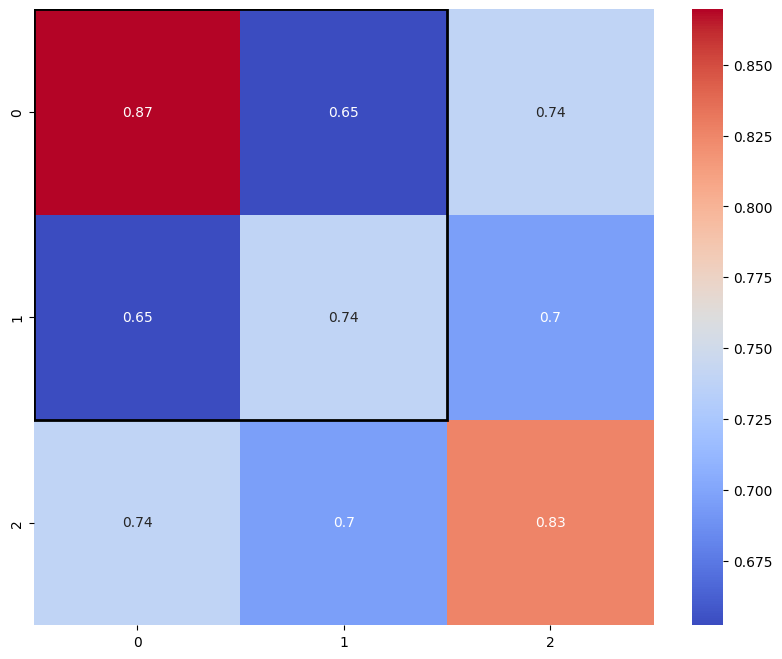

In [15]:
response_0 = (
    "If a hireling is removed from play due to Bad Stuff, the player does not "
    "retain any items the hireling was carrying."
)
response_1 = (
    "If a Hireling is removed from play due to Bad Stuff, the player "
    "loses the items the Hireling was carrying."
)
response_2 = (
    "If a Hireling is removed from play due to Bad Stuff, the player retains "
    "any items the hireling was carrying."
)

responses = [
    {"text": response_0},
    {"text": response_1},
    {"text": response_2},
]

responses = tokenize_responses(responses)
# ngram_consistency_score(responses, ngrams=1)

similarity = ngram_consistency_score(responses, ngrams=1)
visualize_similarity(responses, similarity, 2)

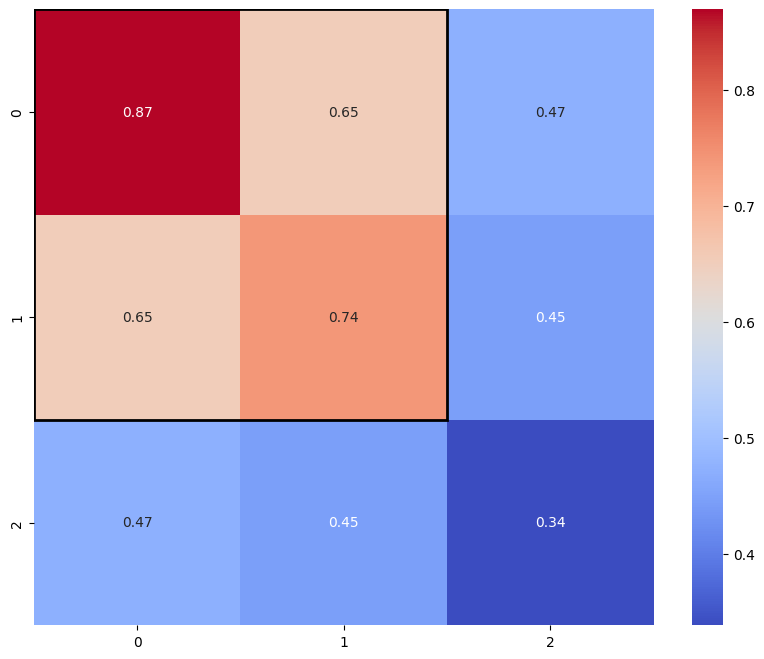

In [16]:
responses = [
    {"text": response_0},
    {"text": response_1},
    {"text": response_2},
]

responses = tokenize_responses(responses)
responses[2]["logprobs"] = [np.log(0.80) for _ in responses[2]["tokens"]]

similarity = consensus_weighted_ngram_consistency_score(responses, ngrams=1)
visualize_similarity(responses, similarity, 2)

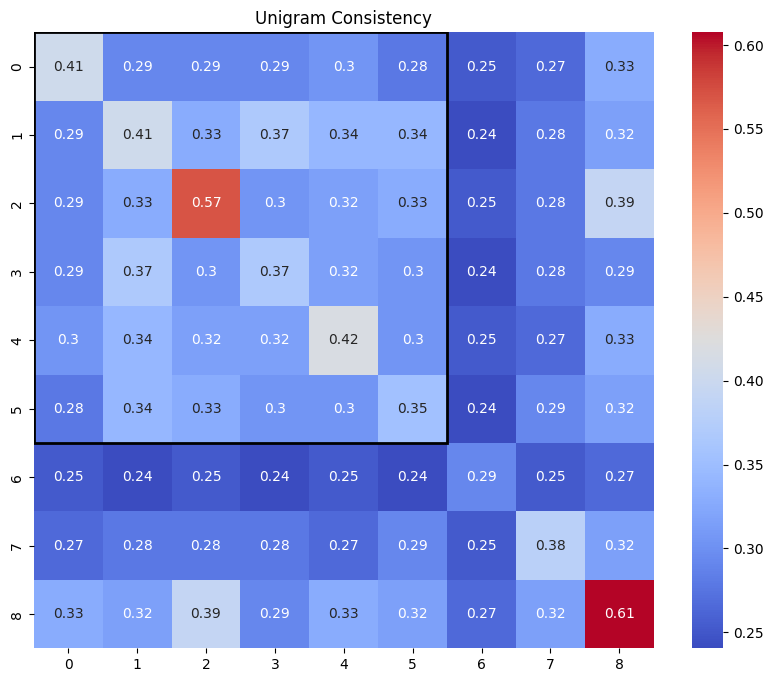

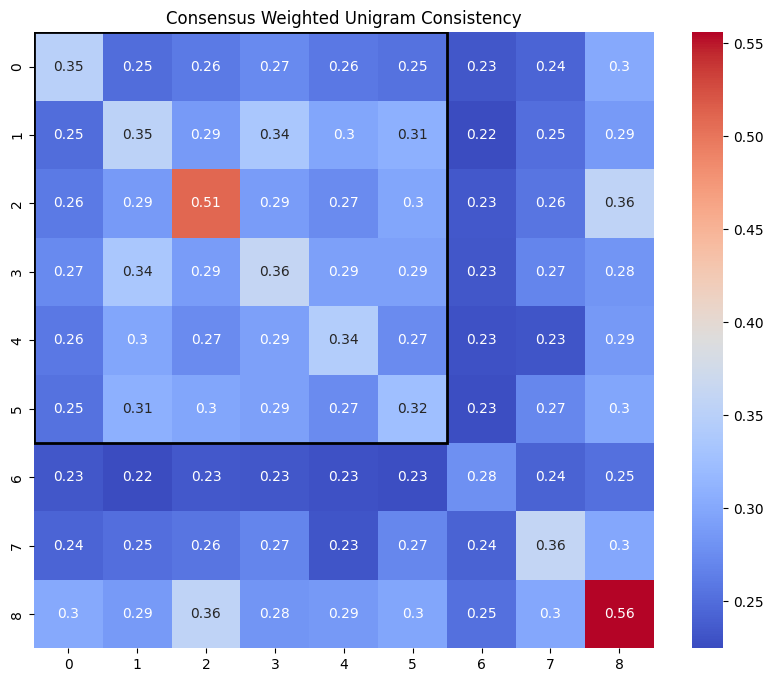

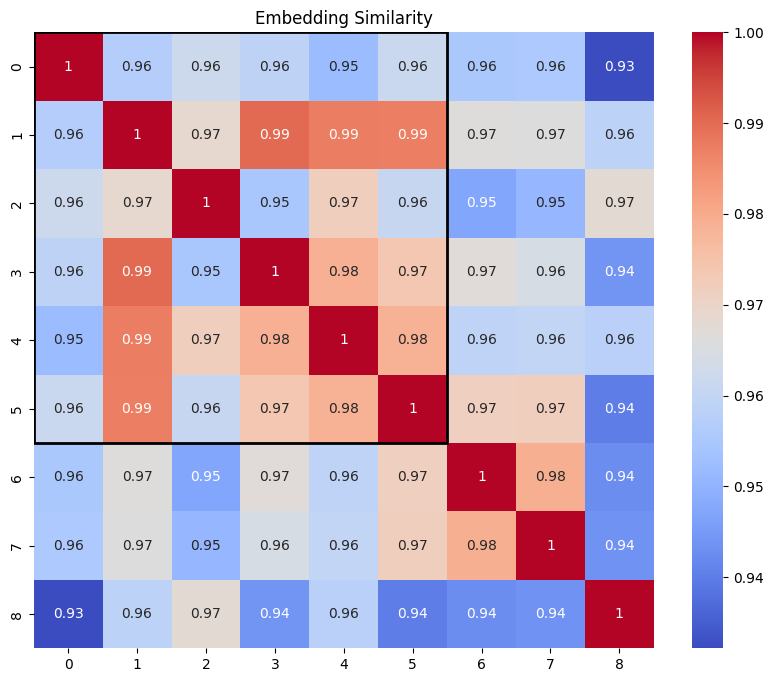

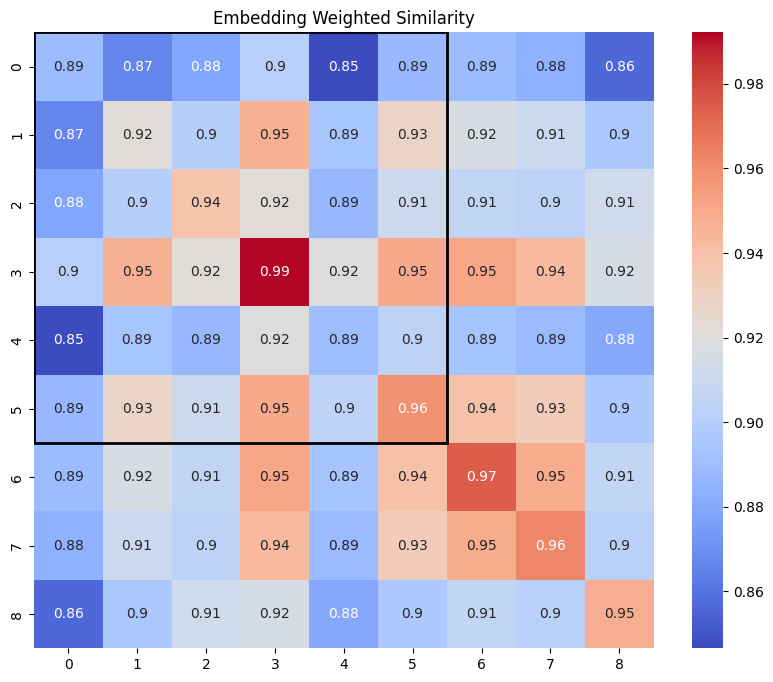

In [32]:
example = {
    'bad_responses': [1, 5, 7], 
    'good_responses': [0, 2, 3, 4, 6, 8], 
    'question': 'If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?', 
    'responses': [
        {
            'logprobs': [0, 0, 0, -2.3515625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'Yes, if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.', 
            'text': 'Since the question asks about Bad Stuff, we can conclude that if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.', 
            'tokens': [24091, 272, 2996, 12373, 684, 9734, 662, 1292, 28725, 478, 541, 18429, 369, 513, 264, 15270, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 15270, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.3305664, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'If a hireling is removed from play due to Bad Stuff, the player retains any items the hireling was carrying.', 
            'text': 'If a hireling is removed from play due to Bad Stuff, the player retains any items the hireling was carrying.', 
            'tokens': [1047, 264, 15270, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1699, 1606, 707, 4907, 272, 15270, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [0, 0, 0, 0, 0, 0, -0.6933594, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.0537109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.05831909, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying. The items go with the Hireling.', 
            'text': 'Based on the rules provided, if a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying. The items go with the Hireling.', 
            'tokens': [24207, 356, 272, 5879, 3857, 28725, 513, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 382, 536, 1905, 403, 10839, 28723, 415, 4907, 576, 395, 272, 382, 536, 1905, 28723]
        }, 
        {
            'logprobs': [-0.054870605, -1.0947266, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.16967773, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.05831909, 0, 0, 0, -0.15124512, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.7578125, 0, 0, 0, -0.09442139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'If a Hireling is removed from play due to Bad Stuff, the items carried by the Hireling go with him, and the player does not retain any of those items.', 
            'text': 'Since Bad Stuff is mentioned as one of the reasons for a Hireling to be removed from play, according to the first rule, the items carried by the Hireling go with him.\n\nAnswer: If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying.', 
            'tokens': [24091, 9734, 662, 1292, 349, 7083, 390, 624, 302, 272, 6494, 354, 264, 382, 536, 1905, 298, 347, 6747, 477, 1156, 28725, 4771, 298, 272, 907, 5918, 28725, 272, 4907, 7158, 486, 272, 382, 536, 1905, 576, 395, 713, 28723, 13, 13, 2820, 16981, 28747, 1047, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 382, 536, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [-0.07891846, 0, 0, -0.05831909, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': "Yes, that's correct. If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying.", 
            'text': 'Based on the provided rules, if a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying.', 
            'tokens': [24207, 356, 272, 3857, 5879, 28725, 513, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 382, 536, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.6933594, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'If a Hireling is removed from play due to Bad Stuff that does not specifically mention discarding items, the player retains the items the Hireling was carrying.', 
            'text': 'If a Hireling is removed from play due to Bad Stuff that does not specifically mention discarding items, the player retains the items the Hireling was carrying.', 
            'tokens': [3381, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 369, 1235, 459, 10107, 4389, 2312, 20003, 4907, 28725, 272, 4385, 1699, 1606, 272, 4907, 272, 382, 536, 1905, 403, 10839, 28723]
        },
        {
            'logprobs': [0, 0, 0, -0.06994629, -0.49804688, -0.42871094, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.1427002, -0.13464355, 0, 0, 0, 0, 0, 0, 0, 0, -0.15124512, 0, -1.2675781, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'When a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying. The items go with the hireling.', 
            'text': 'Based on the rules, when a hireling is removed from play due to Bad Stuff, the items the hireling was carrying go with him. This means that the player does not retain any items the hireling was carrying.', 
            'tokens': [24207, 356, 272, 5879, 28725, 739, 264, 15270, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4907, 272, 15270, 1905, 403, 10839, 576, 395, 713, 28723, 851, 2825, 369, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 15270, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.65966797, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.09442139, 0, 0, 0, 0, -1.0898438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'Yes, when a Hireling is removed from play due to Bad Stuff, the player retains any items the Hireling was carrying.', 
            'text': 'Since the first rule explicitly states that items carried by a Hireling go with him when he is taken away by Bad Stuff, and the second rule does not exclude this situation, we can conclude that when a Hireling is removed from play due to Bad Stuff, the player retains any items the Hireling was carrying.', 
            'tokens': [24091, 272, 907, 5918, 15956, 4605, 369, 4907, 7158, 486, 264, 382, 536, 1905, 576, 395, 713, 739, 400, 349, 3214, 1753, 486, 9734, 662, 1292, 28725, 304, 272, 1676, 5918, 1235, 459, 25482, 456, 4620, 28725, 478, 541, 18429, 369, 739, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1699, 1606, 707, 4907, 272, 382, 536, 1905, 403, 10839, 28723]
        }, 
        {
            'logprobs': [-0.24499512, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.25195312, -0.051635742, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.25195312, 0, 0, 0, 0, 0, 0, 0, 0], 
            'prompted_extraction': 'If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying. The items go with the Hireling.', 
            'text': 'If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying. The items go with the Hireling.', 
            'tokens': [3381, 264, 382, 536, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 382, 536, 1905, 403, 10839, 28723, 415, 4907, 576, 395, 272, 382, 536, 1905, 28723]
        }
    ]
}


good_responses = [example["responses"][i] for i in example["good_responses"]]
bad_responses = [example["responses"][i] for i in example["bad_responses"]]
responses = good_responses + bad_responses

visualize_similarity(
    responses,
    ngram_consistency_score(responses),
    len(good_responses),
    title="Unigram Consistency"
)
visualize_similarity(
    responses, 
    consensus_weighted_ngram_consistency_score(responses),
    len(good_responses),
    title="Consensus Weighted Unigram Consistency"
)
visualize_similarity(
    responses,
    embedding_similarity_score(responses),
    len(good_responses),
    title="Embedding Similarity"
)
visualize_similarity(
    responses,
    embedding_similarity_weighted_score(responses),
    len(good_responses),
    title="Embedding Weighted Similarity"
)

In [5]:
def calculate_average_precision(correct_labels, sorted_predictions):
    correct_set = set(correct_labels)
    cum_correct = 0  # Cumulative count of correct answers found
    precision_sum = 0  # Sum of precision values at each correct answer
    
    for i, pred in enumerate(sorted_predictions):
        if pred in correct_set:
            cum_correct += 1
            precision = cum_correct / (i + 1)  # Precision at this point in the list
            precision_sum += precision
            
    average_precision = precision_sum / len(correct_set) if correct_set else 0
    return average_precision

In [17]:
def compute_and_show_mean_average_precision(test_cases):
    import tabulate
    from functools import partial

    results = []

    for comparison_name, similarity_fn in (
        ("Highest Probability", highest_probability_score),
        ("1-Gram Consistency", ngram_consistency_score), 
        ("1-Gram Consensus Weighted Consistency", consensus_weighted_ngram_consistency_score),
        ("2-Gram Consistency", partial(ngram_consistency_score, ngrams=2)), 
        ("2-Gram Consensus Weighted Consistency", partial(consensus_weighted_ngram_consistency_score, ngrams=2)),
        ("Jina Embeddings", embedding_similarity_score), 
        ("Jina Weighted Embeddings", embedding_similarity_weighted_score)
    ):
        correct_at_top = 0
        averages = []
        for test_case in test_cases:
            responses = test_case["responses"]
            good_responses = [responses[i] for i in test_case["good_responses"]]
            bad_responses = [responses[i] for i in test_case["bad_responses"]]

            # if not bad_responses:
            #     continue

            responses = good_responses + bad_responses

            if similarity_fn is highest_probability_score:
                scores = similarity_fn(responses)
                sorted_indices = np.argsort(scores)[::-1]
                avg_percision = calculate_average_precision(
                    set(range(len(good_responses))),
                    sorted_indices
                )
                averages.append(avg_percision)
                if sorted_indices[0] < len(good_responses):
                    correct_at_top += 1
                continue
        
            scores = generalized_self_consistency_score(
                similarity_fn(responses)
            )
            sorted_indices = np.argsort(scores)[::-1]
            avg_percision = calculate_average_precision(
                set(range(len(good_responses))),
                sorted_indices
            )
            if sorted_indices[0] < len(good_responses):
                correct_at_top += 1
            averages.append(avg_percision)

        results.append(
            (comparison_name, round(sum(averages) / len(averages), ndigits=2), round(correct_at_top / len(averages), ndigits=2))
        )

    results.sort(key=lambda x: x[1], reverse=True)
    return tabulate.tabulate(
        results, 
        headers=["Method", "Mean Average Precision", "Top Correct"], 
        tablefmt="html"
    )

In [35]:
compute_and_show_mean_average_precision([example])

Method,Mean Average Precision,Top Correct
2-Gram Consistency,0.95,1
Jina Embeddings,0.91,1
2-Gram Consensus Weighted Consistency,0.82,1
1-Gram Consistency,0.73,0
1-Gram Consensus Weighted Consistency,0.73,0
Jina Weighted Embeddings,0.7,1
Highest Probability,0.64,1


In [18]:
import json

import meeplemate
from pathlib import Path

PROJECT_DIR = Path(meeplemate.__file__).parent.parent

with open(PROJECT_DIR / "self_consistency_test_cases2.json") as f:
    test_cases = json.load(f)

compute_and_show_mean_average_precision(test_cases_with_compiled_responses(generate_test_case_permutations(test_cases, response_sets_per_question=100), mode="cot_answer"))

Method,Mean Average Precision,Top Correct
2-Gram Consensus Weighted Consistency,0.88,0.86
2-Gram Consistency,0.87,0.85
Jina Embeddings,0.87,0.85
Jina Weighted Embeddings,0.86,0.86
1-Gram Consistency,0.85,0.81
1-Gram Consensus Weighted Consistency,0.85,0.83
Highest Probability,0.81,0.73


## Implement the Thing

In [226]:
cot_chain = (
    prompt | chat_model.bind(temperature=0.7) | StrOutputParser()
)

cot_and_extract_chain = (
    {"answer": cot_chain}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_and_extract_chain.map()
)

outputs = chain.invoke({"context": context_when_take_actions, "question": question})
for output in outputs:
    print(output)
    print()
    print("----")
    print()

Yes, you can play a Go Up a Level card while in combat, as it can be played at any time and is not explicitly restricted to non-combat situations.

----

Yes, you can play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat, as it does not have any limitations or exceptions mentioned in the rules.

----

Yes, you can play a Go Up a Level card while in combat.

----



In [232]:
def select_consensus_response(answers):
    # Create responses and tokenize
    responses = [
        {
            "text": answer
        }
        for answer in answers
    ]

    responses = tokenize_responses(responses)

    # Compute pair-wise similarity scores using bigrams
    similarity_scores = ngram_consistency_score(responses, ngrams=2)

    # Sort responses by highest average similarity
    self_consistency_scores = generalized_self_consistency_score(similarity_scores)

    # Return the answer with highest average similairty
    index_of_best_response = np.argmax(self_consistency_scores)

    return answers[index_of_best_response]


cot_chain = (
    prompt | chat_model.bind(temperature=0.7) | StrOutputParser()
)

cot_and_extract_chain = (
    {"answer": cot_chain}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_and_extract_chain.map()
    | select_consensus_response
)

print(question)
print()

print(
    chain.invoke({"context": context_when_take_actions, "question": question})
)

Can I play a Go Up a Level card while in combat?

Yes, you can play a Go Up a Level card while in combat.


In [127]:
context_steed_rules = """\
No player can have more than one Steed except by using a Cheat! \
card.

Steeds are Items, and follow normal Item rules. Anything that \
affects an Item can affect a Steed.

Steeds carry themselves. A Steed is “Big,” but it does not count \
against the number of Big items you can carry (in fact, some let \
you carry more Big things). The “Big” designation on Steeds is to \
control what Traps and Curses affect them, and to keep Thieves \
from pocketing them and walking off.

There are a few Items that specifically enhance Steeds. Steeds \
cannot use Items unless the Item card specifically says so, and Item \
Enhancers don’t affect Steed-enhancing Items.
"""

In [166]:
context_big_items = """\
Most Treasures are Items. Items have a Gold Piece value. “No Value” is \
equivalent to zero Gold Pieces, and a “No Value” card is considered an Item.

All Items you have in play are considered “carried.” Items that are actually \
giving you a bonus are “equipped.” You should indicate Items that are not \
equipped by turning the cards sideways. You may not alter the status of your \
Items during a combat or while running away.

Anyone can carry any Item (except for extra Big items; see below), but you \
may equip only one Headgear, one suit of Armor, one pair of Footgear, and \
two “1 Hand” Items (or one “2 Hands” Item) . . . unless you have a card that \
lets you ignore these limits, such as Hireling or Cheat!, or unless one of \
the cards says otherwise. If you are carrying two Headgear cards, for instance, \
you can equip only one of them at a time.

Big Items: You may carry any number of Small items, but only one Big \
one. (Any item not marked Big is considered Small.) You may not discard \
one Big item to play another; you must sell the first Item, trade it, lose it \
to a Curse or Bad Stuff, or discard it to power a Class or Race ability.
"""

In [178]:
context_hireling = """\
You can play a Hireling at any time, even in combat, as long as you have only \
one Hireling in play at a time. If you draw a face-up Hireling, you may put it \
in your hand if you cannot (or don’t want to) put it in play. You may discard \
a Hireling at any time.

A Hireling is not an Item unless it has a price on it. You may only trade \
Hirelings that have a Gold Piece value.

A Cheat! card can be used to give you an extra Hireling, or to let a Hireling \
carry an item he normally could not (but why not just use the card on \
yourself?). No power on heaven or earth will let the Budget Hireling carry \
anything.
"""

In [193]:
context_items = """\
Anyone can carry any Item (except for extra Big items; see below), but you
may equip only one Headgear, one suit of Armor, one pair of Footgear, and
two “1 Hand” Items (or one “2 Hands” Item) . . . unless you have a card that
lets you ignore these limits, such as Hireling or Cheat!, or unless one of
the cards says otherwise. If you are carrying two Headgear cards, for instance,
you can equip only one of them at a time.
"""

In [21]:
from langchain_core.runnables import RunnableLambda

def build_duplicator(n):
    def duplicator(x):
        return [x for _ in range(n)]
    return RunnableLambda(duplicator)

cot_chain = (
    {"answer": prompt | chat_model | StrOutputParser()}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_chain.map()
)

outputs = chain.invoke({"context": context, "question": question})
for output in outputs:
    print(output)
    print()
    print("----")
    print()

You cannot play a Go Up a Level card while in combat.

----

You cannot play a Go Up a Level card while in combat.

----

You cannot play a Go Up a Level card while in combat.

----

You cannot play a Go Up a Level card while in combat.

----

You cannot play a Go Up a Level card while in combat.

----



In [207]:
from langchain_core.runnables import RunnableLambda

def build_duplicator(n):
    def duplicator(x):
        return [x for _ in range(n)]
    return RunnableLambda(duplicator)

cot_chain = (
    {"answer": prompt | chat_model.bind(temperature=0.7) | StrOutputParser()}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_chain.map()
)

outputs = chain.invoke({"context": context_steed_rules, "question": "Can I have two steeds?"})
for output in outputs:
    print(output)
    print()
    print("----")
    print()

Yes, a player can have two Steeds if they use a Cheat! card.

----

Yes, you can have two steeds if you use a Cheat! card.

----

Yes, you can have two Steeds if you use a Cheat! card. Otherwise, you can only have one Steed.

----

The answer is: You can have two Steeds only if a Cheat! card has been played or is in play. Otherwise, you cannot have more than one Steed.

----

You cannot have two Steeds without using a Cheat! card.

----



In [22]:
cot_chain = (
    {"answer": prompt | chat_model.bind(temperature=0.7) | StrOutputParser()}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_chain.map()
)

outputs = chain.invoke({"context": context, "question": question})
for output in outputs:
    print(output)
    print()
    print("----")
    print()

No, you cannot play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----

Yes, you can play a Go Up a Level card while in combat.

----



In [23]:
def choose_consensus_answer(answers):
    responses = [
        {
            "text": answer
        }
        for answer in answers
    ]
    responses = tokenize_responses(responses)

    score = ngram_consistency_score(responses, ngrams=1)
    score = generalized_self_consistency_score(score)

    sorted_indicies = np.argsort(score)[::-1]
    best_answer = answers[sorted_indicies[0]]
    return best_answer


cot_chain = (
    {"answer": prompt | chat_model.bind(temperature=0.7) | StrOutputParser()}
    | extract_prompt
    | chat_model
    | StrOutputParser()
)

chain = (
    build_duplicator(5)
    | cot_chain.map()
    | choose_consensus_answer
)

print(
    chain.invoke({"context": context, "question": question})
)

No, you cannot play a Go Up a Level card while in combat.


In [2]:
def slurp_jsonl(file):
    import json
    with open(file) as f:
        return [json.loads(line) for line in f]

In [25]:
extracted = slurp_jsonl('extracted_cot_with_logprobs.jsonl')

In [26]:
questions = [x['question'] for x in extracted]

# Remove duplicate questions but preserve the order
questions = list(dict.fromkeys(questions))

for i, q in enumerate(questions):
    print(i, q)

0 If a monster does not pursue me because my level is too low, can I still loot the room?
1 Can I sell items from my hand to go up a level, assuming I can sell 1,000 gold pieces worth?
2 Can I have multiple steeds equipped at the same time?
3 If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?
4 How many players can help me in a combat by adding their combat level?
5 Can I play a Go Up a Level card during combat on my turn?
6 Does a player retain their princess card in play if they die?
7 Can I carry multiple big items so long as only one is equipped?
8 What is an item in play but not equipped called?
9 If after breaking down the door I draw a steed face up, what are my options?
10 Can I play a Super Munchkin card without a class card?
11 When can I play a Super Munchkin card?
12 What cards can I trade with other players?
13 When can I play a Hireling?
14 Can I play a Hireling card if I already have a Hireling in play?
15 Whe

In [12]:
def find_sentence_start(text, pos):
    # Find start sentence indicator
    while pos > 0 and text[pos] not in ['.', ':', '!', '?', '\n']:
        pos -= 1
    
    pos += 1
    
    # Remove whitespace
    while pos < len(text) and text[pos] in [' ', '\n', '\t']:
        pos += 1
    
    return pos

def find_sentence_end(text, pos):
    # Find end sentence indicator
    while pos < len(text) and text[pos] not in ['.', '!', '?', '\n']:
        pos += 1
    
    if pos < len(text)-1:
        pos += 1
    
    # Remove whitespace
    while pos < len(text) and text[pos] in [' ', '\n', '\t']:
        pos += 1
    
    return pos

def find_extracted_answer_in_cot(answer, cot):
    # Assume the extracted answer is at the end of CoT
    # Assume the extracted answer is, if anything, more concise than the answer
    # produced in CoT

    # Initial guess of answer position in CoT
    answer_pos = len(cot) - len(answer)
    if answer_pos < 0:
        return (0, len(cot))
    
    # How far back to beginning of sentence
    back_pos = find_sentence_start(cot, answer_pos)

    # How far forward to end of sentence
    forward_pos = find_sentence_end(cot, answer_pos + len(answer))

    # Find sentence boundary we are closest to
    if (answer_pos - back_pos > forward_pos - answer_pos) and forward_pos < len(cot):
        answer_pos = forward_pos
    else:
        answer_pos = back_pos
    
    # # Work backwards to the start/end of a sentence, paragraph, etc.
    # while answer_pos > 1 and cot[answer_pos-1] not in ['.', '!', '?', ';', ':', '\n']:
    #     answer_pos -= 1
    
    # # Now work forwards removing whitespace
    # while answer_pos < len(cot) and cot[answer_pos] in [' ', '\n', '\t']:
    #     answer_pos += 1

    return (answer_pos, len(cot))

def find_tokens_from_str_pos(token_strings, start, end):
    str_pos = 0
    token_start_pos = None
    for i, token in enumerate(token_strings):
        if token_start_pos is None and str_pos >= start:
            if str_pos > start and i > 0:
                token_start_pos = i - 1
            else:
                token_start_pos = i
        if str_pos >= end:
            return (token_start_pos, i)
        str_pos += len(token)
    return (token_start_pos, len(token_strings))

In [18]:
test_cases = [
    {
        "cot_chain": """To answer the question, let's break down the rules related to steeds and their equipping:

1. Steeds are an essential part of a Munchkin's arsenal, providing valuable bonuses and enhancing the player's abilities.
2. A player can only possess one Steed at a time, unless a Cheat! card is used.
3. Steeds are classified as "Big" items, but they do not count towards the limit of Big items a player can carry.
4. Steeds themselves cannot use Items unless the card explicitly states so.

From these rules, we can deduce that a player can only have one Steed equipped at a time, unless they play a Cheat! card. This means that, by default, a player cannot have multiple steeds equipped simultaneously.""",
        "prompted_extraction": """No, a player cannot have multiple steeds equipped at the same time, unless they play a Cheat! card.""",
        "cot_extracted": """From these rules, we can deduce that a player can only have one Steed equipped at a time, unless they play a Cheat! card. This means that, by default, a player cannot have multiple steeds equipped simultaneously.""",
    },
    {
        "cot_chain": """First, let's identify the relevant information from the provided rules:

1. If your Hireling is taken away by a trap/curse, bad stuff, or a change in loyalty, the items go with him!
2. If your Hireling is killed, you loot the body yourself and keep the items.

Now, let's analyze the question:

The question asks if a player retains any items a hireling was carrying if the hireling is removed from play due to Bad Stuff.

Based on the information provided, we can see that if a hireling is taken away by a trap/curse, bad stuff, or a change in loyalty, the items go with him. However, the question specifically asks about the situation where the hireling is removed due to Bad Stuff.

Since there is no explicit exception or variation mentioned in the rules for this specific scenario, we can conclude that the general rule applies: if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.""",
        "prompted_extraction": """If a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.""",
        "cot_extracted": """if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.""",
    },
    {
        "cot_chain": """In this context, you have drawn a Steed face-up after breaking down the door. Here's a step-by-step breakdown of the situation:

1. You have just completed the "Kick Open The Door" phase of your turn.
2. You drew a Steed card from the Door deck.
3. Since it's a Steed, you must choose whether to treat it as a monster or not.

If you choose to treat it as a monster:

1. The Steed's Level is twice the combat bonus on the card.
2. Defeating the Steed results in one Treasure and one level gained.
2. Monster Enhancers can be played on the Steed, and they have their normal effects.
3. The penalty for attacking a Steed as a monster is "Lose a level."

If you choose to treat it as an Item:

1. You can add it to your hand or play it immediately.
2. Steeds are subject to normal Item rules, such as the limit of Big items and the possibility of being enhanced by Item Enhancers.

In summary, if you draw a Steed face-up after breaking down the door, you must decide whether to treat it as a monster or an Item. If treated as a monster, you fight it with its Level being twice the combat bonus on the card. If treated as an Item, you can add it to your hand or play it immediately, subject to normal Item rules.""",
        "prompted_extraction": """If you draw a Steed face-up after breaking down the door, you must decide whether to treat it as a monster or an Item. If treated as a monster, you fight it with its Level being twice the combat bonus on the card. If treated as an Item, you can add it to your hand or play it immediately, subject to normal Item rules.""",
        "cot_extracted": """In summary, if you draw a Steed face-up after breaking down the door, you must decide whether to treat it as a monster or an Item. If treated as a monster, you fight it with its Level being twice the combat bonus on the card. If treated as an Item, you can add it to your hand or play it immediately, subject to normal Item rules.""",
    },
]

for test_case in test_cases:
    cot_chain = test_case["cot_chain"]
    prompted_extraction = test_case["prompted_extraction"]
    cot_extracted = test_case["cot_extracted"]

    # Find the position of the prompted extraction in the COT chain
    start, end = find_extracted_answer_in_cot(prompted_extraction, cot_chain)
    result = cot_chain[start:end]

    if result.strip() != cot_extracted.strip():
        print("Test case failed!")
        print("Expected CoT extraction:", cot_extracted)
        print("Actual:", result)
        print()
        continue

In [8]:
# modes: cot_answer, cot, extracted

def compile_response(sample, mode="cot_answer"):
    if mode == "cot_answer":
        # In this mode, we try to separate the answer from the reasoning in the
        # CoT response. We assume that the answer is at the end of the CoT
        # response and leverage the extraction generation to find the position
        # of the answer in the CoT response.

        # Find the position where the answer is in the CoT response
        start, end = find_extracted_answer_in_cot(
            sample["extract_generation"]["text"],
            sample["cot_generation"]["text"]
        )

        # Get the sub-string from the CoT response
        cot_answer_substring = sample["cot_generation"]["text"][start:end]

        # Find the tokens that correspond to the substring
        tokens = sample["cot_generation"]["generation_info"]["details"]["tokens"]
        token_texts = [t["text"] for t in tokens]
        token_start, token_end = find_tokens_from_str_pos(token_texts, start, end)
        token_texts = token_texts[token_start:token_end]
        token_ids = [t["id"] for t in tokens[token_start:token_end]]
        logprobs = [t["logprob"] for t in tokens[token_start:token_end]]
        return {
            "text": cot_answer_substring,
            "tokens": token_ids,
            "logprobs": logprobs,
            "prompted_extraction": sample["extract_generation"]["text"],
        }
    elif mode == "cot":
        # In this mode, we use the whole CoT response (reasoning + answer) for
        # the tokens and logprobs
        return {
            "text": sample["cot_generation"]["text"],
            "tokens": [t["id"] for t in sample["cot_generation"]["generation_info"]["details"]["tokens"]],
            "logprobs": [t["logprob"] for t in sample["cot_generation"]["generation_info"]["details"]["tokens"]],
            "prompted_extraction": sample["extract_generation"]["text"],
        }
    elif mode == "extracted":
        # In this mode, we ignore the CoT response and just use the extracted
        # answer. The logprobs in this case are not particularly meaningful as
        # they will simply represent how confident the LLM is in its ability to
        # find the answer in the CoT response.
        return {
            "text": sample["extract_generation"]["text"],
            "tokens": [t["id"] for t in sample["extract_generation"]["generation_info"]["details"]["tokens"]],
            "logprobs": [t["logprob"] for t in sample["extract_generation"]["generation_info"]["details"]["tokens"]],
            "prompted_extraction": sample["extract_generation"]["text"],
        }
    else:
        raise ValueError(f"Invalid mode: {mode}")

In [7]:
def test_cases_with_compiled_responses(test_cases, mode="cot_answer"):
    result = []
    for test_case in test_cases:
        compiled_responses = [
            compile_response(response, mode=mode)
            for response in test_case["responses"]
        ]

        result.append(
            {
                **test_case,
                "responses": compiled_responses
            }
        )
    return result

In [3]:
from pprint import pprint
import json

extracted = slurp_jsonl('extracted_cot_with_logprobs2.jsonl')

extracted_by_group = {}
for sample in extracted:
    group = extracted_by_group.setdefault(sample["self_consistency_run_id"], {})
    group.setdefault(sample["question"], []).append(sample)

question_and_responses = []
for self_consistency_results in extracted_by_group.values():
    for question, samples in self_consistency_results.items():
        responses = [
            {"cot_generation": sample["cot_generation"], "extract_generation": sample["extract_generation"]} 
            for sample in samples
        ]
        question_and_responses.append({"question": question, "responses": responses})

# with open("self_consistency_test_cases2.json", "w") as f:
#     json.dump(question_and_responses, f, indent=4)

# responses_subset = question_and_responses[3][1][2:4]
# vectors, _ = build_ngram_logprob_vectors(responses_subset)
# print(vectors)

# similarity = consensus_weighted_ngram_consistency_score(responses_subset)
# print(similarity)
# print()
# print()
# for question, responses in question_and_responses:
#     if "If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?" not in question:
#         continue
#     # Pick 9 responses at random
#     # np.random.shuffle(responses[:])
#     # responses = responses[:9]
#     scores = generalized_self_consistency_score(consensus_weighted_ngram_consistency_score(responses))
#     sorted_indices = np.argsort(scores)[::-1]

#     print("# Question")
#     print(question)
#     print()
#     print(f"## Responses")
#     results = []
#     for i in sorted_indices:
#         # print(f"### Response {i}")
#         results.append({k: v for k, v in responses[i].items() if k in ["text", "tokens", "logprobs"]})
#         # print(responses[i]["text"])
#         # print(responses[i]["tokens"])
#         # print(responses[i]["logprobs"])
#         # print()
    
#     print(results)
    
#     print()
#     print()

    
# similarity = consensus_weighted_ngram_consistency_score(responses, ngrams=1)
# scores = generalized_self_consistency_score(similarity)

# # Sort the scores in descending order and get the indices
# sorted_indices = np.argsort(scores)[::-1]

# # Print responses in order of self-consistency
# for i in sorted_indices:
#     print(responses[i]["prompted_extraction"])

In [10]:
import random

def generate_test_case_permutations(test_cases, response_count_for_consistency=9, response_sets_per_question=10):
    question_response_value_tuples = []
    for test_case in test_cases:
        good_response_indices = test_case["good_responses"]
        for i, response in enumerate(test_case["responses"]):
            question_response_value_tuples.append((test_case["question"], response, i in good_response_indices))

    questions_to_responses = {}
    for question, response, value in question_response_value_tuples:
        questions_to_responses.setdefault(question, []).append((response, value))

    result = []
    for question, response_value_pairs in questions_to_responses.items():
        for _ in range(response_sets_per_question):
            response_value_selected = random.sample(response_value_pairs, k=response_count_for_consistency)
            responses, values = zip(*response_value_selected)
            good_response_indices = [i for i, v in enumerate(values) if v]
            bad_response_indices = [i for i, v in enumerate(values) if not v]
            result.append({
                "question": question,
                "responses": responses,
                "good_responses": good_response_indices,
                "bad_responses": bad_response_indices
            })
    return result

In [21]:
import json
with open("self_consistency_test_cases2.json", "r") as f:
    test_cases = json.load(f)

In [31]:
hireling_items_test_cases = [
    test_case for test_case in test_cases if "hireling is removed from play" in test_case["question"].lower()
]

from pprint import pprint
pprint(test_cases_with_compiled_responses([hireling_items_test_cases[0]])[0], width=1_000_000_000)

{'bad_responses': [1, 5, 7], 'good_responses': [0, 2, 3, 4, 6, 8], 'question': 'If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?', 'responses': [{'logprobs': [0, 0, 0, -2.3515625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'prompted_extraction': 'Yes, if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.', 'text': 'Since the question asks about Bad Stuff, we can conclude that if a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.', 'tokens': [24091, 272, 2996, 12373, 684, 9734, 662, 1292, 28725, 478, 541, 18429, 369, 513, 264, 15270, 1905, 349, 6747, 477, 1156, 2940, 298, 9734, 662, 1292, 28725, 272, 4385, 1235, 459, 16815, 707, 4907, 272, 15270, 1905, 403, 10839, 28723]}, {'logprobs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [56]:
generated = generate_test_case_permutations(test_cases, response_sets_per_question=20)
len(generated[0]["responses"])

9

In [5]:
import gradio as gr

try:
    demo.close()
except:
    pass

gr.close_all()

current_index = -1
data_to_process = test_cases

def update_selected(selected):
    global current_index
    
    if current_index > -1:
        not_selected = [i for i in range(len(data_to_process[current_index]["responses"])) if i not in selected]
        data_to_process[current_index]["good_responses"] = selected
        data_to_process[current_index]["bad_responses"] = not_selected

    print(selected)
    current_index += 1

    if current_index >= len(data_to_process):
        current_index = -1
        return (
            gr.Markdown("## Done!"),
            gr.CheckboxGroup([], value=None),
            gr.Button("Restart")
        )

    options = [
        (
            data_to_process[current_index]["responses"][i]["extract_generation"]["text"], 
            i
        )
        for i in range(len(data_to_process[current_index]["responses"]))
    ]
    good_response_indices = data_to_process[current_index].get("good_responses", [])
    return (
        gr.Markdown("## " + data_to_process[current_index]["question"]),
        gr.CheckboxGroup(choices=options, value=good_response_indices),
        gr.Button("Submit")
    )

with gr.Blocks() as demo:
    text = gr.Markdown()
    checkboxes = gr.CheckboxGroup(label="Responses")
    submit_button = gr.Button("Start")

    submit_button.click(update_selected, inputs=[checkboxes], outputs=[text, checkboxes, submit_button])


demo.launch(height=2000, inline=True, server_name="0.0.0.0")

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://0.0.0.0:7860

To create a public link, set `share=True` in `launch()`.


[]
[5]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 3, 4, 6, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [17]:
len([sample for sample in data_to_process if "good_responses" in sample]) / len(data_to_process)

1.0

In [19]:
with open("self_consistency_test_cases2.json", "w") as f:
    json.dump(data_to_process, f)

In [186]:
gr.__version__

'4.19.2'

In [187]:
gr.close_all()

Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7860
Closing server running on port: 7861
Closing server running on port: 7862
Closing server running on port: 7860


In [ ]:
for question in questions:
    print("# Question")
    print()
    print(question)
    print()
    print("## Answers")
    print()
    for sample in extracted:
        if sample['question'] == question:
            print(sample["extract_generation"]["text"])
            print()
    print()
    print()

In [ ]:
# Get 10 random items from extracted, but do not mutate the list
import random
extracted_sample = random.sample(extracted, 10)

for sample in extracted_sample:
    start, end = find_extracted_answer_in_cot(sample["extract_generation"]["text"], sample["cot_generation"]["text"])
    extracted_string = sample["cot_generation"]["text"][start:end]
    tokens = sample["cot_generation"]["generation_info"]["details"]["tokens"]
    print("## Extracted")
    print(sample["extract_generation"]["text"])
    print()
    print("## From CoT")
    print(extracted_string)
    print()
    print("## CoT")
    print(sample["cot_generation"]["text"])
    print("-------")
    print()
    print()



# start, end = find_extracted_answer_in_cot(generations_badstuff[3]["extract_generation"]["text"], generations_badstuff[3]["cot_generation"]["text"])
# print(generations_badstuff[3]["cot_generation"]["text"][start:end])
# print()
# print((start, end))
# print()
# print("## Tokens")
# tokens = generations_badstuff[3]["cot_generation"]["generation_info"]["details"]["tokens"]
# pprint(find_tokens_from_str_pos(tokens, start, end))

In [30]:
from pprint import pprint
pprint(generations_badstuff[3]["cot_generation"]["generation_info"])

NameError: name 'generations_badstuff' is not defined

In [58]:
print("## CoT generation")
# print(generations_badstuff[0]["cot_generation"]["generation_info"]["details"]["tokens"])
print(generations_badstuff[3]["cot_generation"]["text"])
print()
print("## Extracted")
print(generations_badstuff[3]["extract_generation"]["text"])

## CoT generation
Part 1: Understanding the context

The question asks about the fate of items carried by a hireling when the hireling is removed from play due to Bad Stuff. To answer this, we need to look at the relevant rules:

1. Hirelings: This rule defines what hirelings are and how they function in the game.
2. Hireling Items: This rule explains what happens to items carried by a hireling when the hireling is sacrificed, killed, or taken away by a trap/curse.
3. Hirelings and Monster Bonuses: This rule explains how hireling types affect the player's interaction with monsters.
4. Items: This rule explains the basics of items, their value, and how they can be carried and equipped.
5. Hirelings and Munchkin: This rule explains how hirelings affect the interaction between players and monsters based on race, class, and sex.
6. Hirelings and Gender: This rule clarifies the gender of hirelings and how it affects their interaction with monsters or items.
7. Hirelings and Cheating: This r